In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import utils

In [2]:
color_discrete_map = {
    "ORF": "rgb(0, 158, 115)",
    "CRISPR": "rgb(213, 94, 0)",
}

In [3]:
orf_profiles_df = pd.read_parquet(
    "../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet"
)

phenotype_df = pd.read_csv(
    "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony.csv.gz",
    usecols=["Metadata_JCP2022", "below_corrected_p"],
).query("below_corrected_p == True")

orf_profiles_df = orf_profiles_df.merge(
    phenotype_df, on="Metadata_JCP2022", how="inner"
).drop(columns=["below_corrected_p"])

orf_profiles_df = utils.consensus(orf_profiles_df, "Metadata_JCP2022")

metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep="\t"
)
orf_profiles_df = orf_profiles_df.merge(metadata_df, on="Metadata_JCP2022", how="left")

orf_profiles_df.shape

(7817, 3664)

In [4]:
crispr_profiles_df = pd.read_parquet(
    "../profiles/profiles_wellpos_cc_var_mad_outlier_crispr.parquet"
)

phenotype_df = pd.read_csv(
    "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected.csv.gz",
    usecols=["Metadata_JCP2022", "below_corrected_p"],
).query("below_corrected_p == True")

crispr_profiles_df = crispr_profiles_df.merge(
    phenotype_df, on="Metadata_JCP2022", how="inner"
).drop(columns=["below_corrected_p"])

crispr_profiles_df = utils.consensus(crispr_profiles_df, "Metadata_JCP2022")

metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep="\t"
)
crispr_profiles_df = crispr_profiles_df.merge(
    metadata_df, on="Metadata_JCP2022", how="left"
)

crispr_profiles_df.shape

(5546, 3670)

In [5]:
protein_class_list = [
    "Enzymes",
    "Transporters",
    "G-protein coupled receptors",
    "Transcription factors",
    "Immunoglobulin genes",
    "T-cell receptor genes",
]

orf_profiles_df = (
    orf_profiles_df
    .assign(col=lambda x: x["Metadata_protein_class"].str.split("|"))
    .explode("col")
    .query("col in @protein_class_list")
    .drop(columns=["Metadata_protein_class"])
    .rename(columns={"col": "Metadata_protein_class"})
    .drop_duplicates(subset="Metadata_JCP2022", keep="first")
)

crispr_profiles_df = (
    crispr_profiles_df
    .assign(col=lambda x: x["Metadata_protein_class"].str.split("|"))
    .explode("col")
    .query("col in @protein_class_list")
    .drop(columns=["Metadata_protein_class"])
    .rename(columns={"col": "Metadata_protein_class"})
    .drop_duplicates(subset="Metadata_JCP2022", keep="first")
)

In [6]:
selected_feature_names_df = pd.read_csv('output/selected_feature_names.csv')

In [7]:
present_features = []

for feature_name_1, feature_name_2 in selected_feature_names_df.values:
    if (
        feature_name_1 in orf_profiles_df.columns
        and feature_name_2 in orf_profiles_df.columns
    ):
        print(f"{feature_name_1} and {feature_name_2} is in the profiles")
        present_features.append(feature_name_1)
        present_features.append(feature_name_2)

orf_df = orf_profiles_df[present_features].copy()
orf_df = (
    orf_df.loc[:, ~orf_df.columns.duplicated()]
    .copy()
    .assign(Modality="ORF")
    .assign(Metadata_protein_class=orf_profiles_df.Metadata_protein_class)
    .assign(Metadata_molecular_function=orf_profiles_df.Metadata_molecular_function)
    .assign(Metadata_Symbol=orf_profiles_df.Metadata_Approved_Symbol)
)

Nuclei_Texture_AngularSecondMoment_ER_10_01_256 and Nuclei_Texture_AngularSecondMoment_RNA_10_01_256 is in the profiles
Nuclei_Granularity_1_RNA and Cytoplasm_AreaShape_Solidity is in the profiles
Nuclei_AreaShape_Area and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_DNA and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_RNA and Cells_AreaShape_Area is in the profiles


In [8]:
present_features = []

for feature_name_1, feature_name_2 in selected_feature_names_df.values:
    if (
        feature_name_1 in crispr_profiles_df.columns
        and feature_name_2 in crispr_profiles_df.columns
    ):
        print(f"{feature_name_1} and {feature_name_2} is in the profiles")
        present_features.append(feature_name_1)
        present_features.append(feature_name_2)

crispr_df = crispr_profiles_df[present_features].copy()
crispr_df = (
    crispr_df.loc[:, ~crispr_df.columns.duplicated()]
    .copy()
    .assign(Modality="CRISPR")
    .assign(Metadata_protein_class=crispr_profiles_df.Metadata_protein_class)
    .assign(Metadata_molecular_function=crispr_profiles_df.Metadata_molecular_function)
    .assign(Metadata_Symbol=orf_profiles_df.Metadata_Approved_Symbol)
)

Nuclei_Texture_AngularSecondMoment_ER_10_01_256 and Nuclei_Texture_AngularSecondMoment_RNA_10_01_256 is in the profiles
Nuclei_Granularity_1_RNA and Cytoplasm_AreaShape_Solidity is in the profiles
Nuclei_AreaShape_Area and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_DNA and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_RNA and Cells_AreaShape_Area is in the profiles


In [9]:
df = pd.concat([orf_df, crispr_df], ignore_index=True)

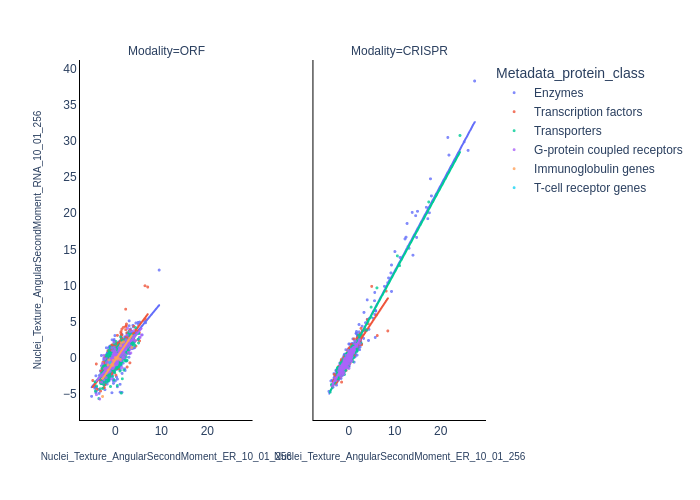

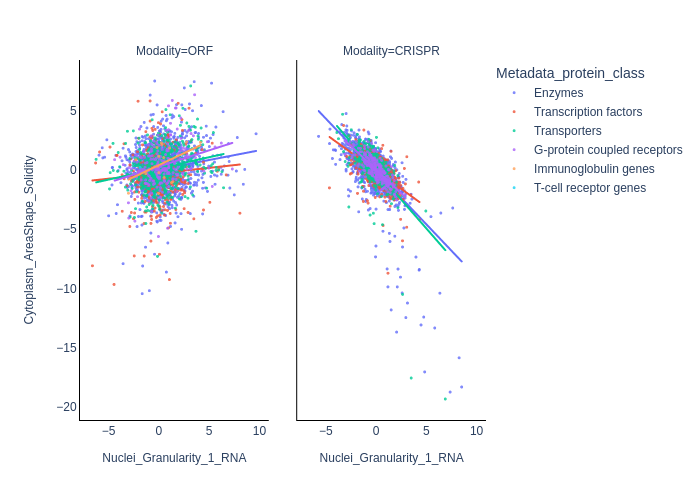

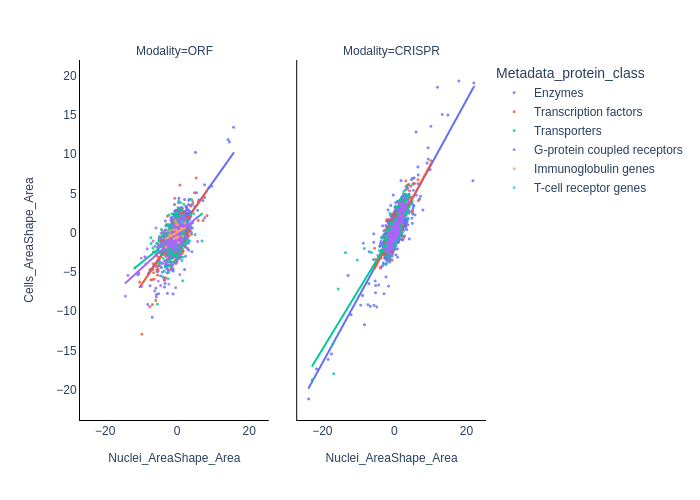

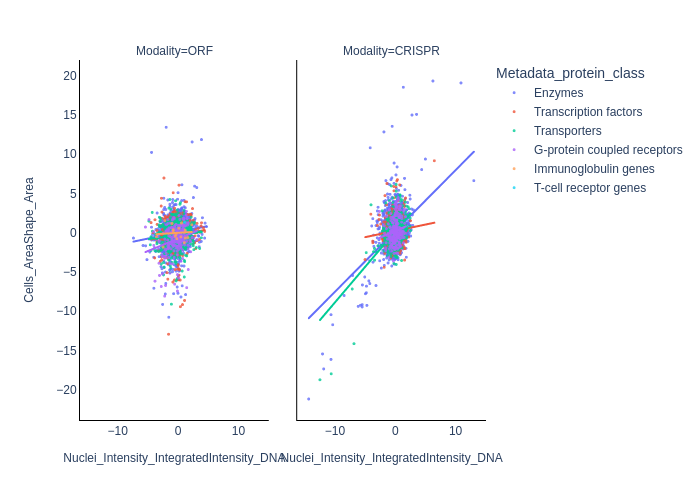

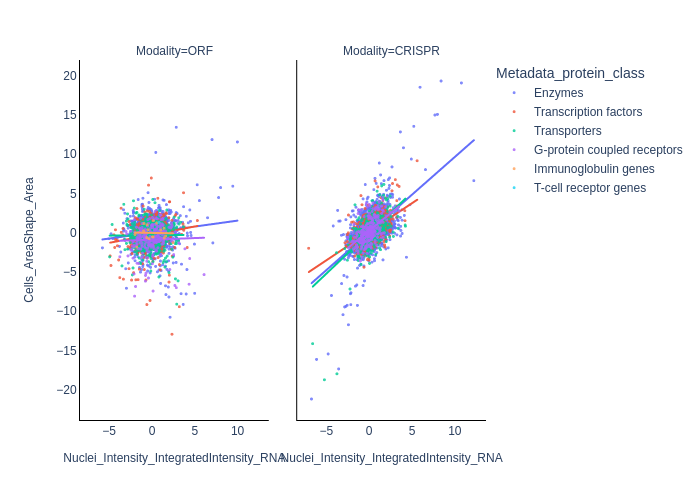

In [10]:
for feature_name_1, feature_name_2 in selected_feature_names_df.values:
    if len(feature_name_1) > 40:
        font_size = 10
        facet_col_spacing = 0.15
    else:
        font_size = 12
        facet_col_spacing = 0.07
    fig = px.scatter(
        df,
        x=feature_name_1,
        y=feature_name_2,
        facet_col="Modality",
        facet_col_spacing=facet_col_spacing,
        color="Metadata_protein_class",
        # color_discrete_map=color_discrete_map,
        trendline="ols",
        opacity=0.8,
        hover_data=["Metadata_Symbol","Metadata_molecular_function"],
    ).update_layout(
        xaxis1=dict(title=feature_name_1, linecolor="#000000", title_font=dict(size=font_size)),
        xaxis2=dict(title=feature_name_1, linecolor="#000000", title_font=dict(size=font_size)),
        yaxis1=dict(title=feature_name_2, linecolor="#000000", title_font=dict(size=font_size)),
        yaxis2=dict(linecolor="#000000"),
        plot_bgcolor="rgba(0, 0, 0, 0)",
    ).update_traces(marker=dict(size=3))
    fig.show("png")
    fig.write_image(f"figures/{feature_name_1}_{feature_name_2}.png", width = 640, height = 480,scale=2)
    fig.write_image(f"figures/{feature_name_1}_{feature_name_2}.svg", width = 640, height = 480, scale=2)
    fig.write_html(f"figures/{feature_name_1}_{feature_name_2}.html")